In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import os
from torch.utils.data import Dataset
import cv2
from tqdm import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
class MyDataset(Dataset):

    def __init__(self, len, home_directory, noise=2, mode="Train",augment=False):
      self.augment = augment
      if self.augment:
        self.len = 3*len
      else:
        self.len = len
      self.examples = []
      self.iter_index = 0
      self.X = torch.empty((self.len, 128,128))
      self.Y = torch.empty((self.len,128,128), dtype=torch.long)
      self.input_directory = os.path.join(home_directory, mode, 'input')
      self.mask_directory = os.path.join(home_directory, mode, 'mask')
      self.augmentation = augment
      print("dataset input path {}".format(self.input_directory))
      print("dataset mask path {}".format(self.mask_directory))
      print(self.len)
      # mask_names = os.listdir(self.mask_directory)
      # mask_names.sort()
      
      self.set_dataset()
      # self.set_dataset(self.mask_directory, mask_names, False)

    def set_dataset(self):
      input_names = os.listdir(self.input_directory)
      input_names.sort()
      index = 0
      for name in input_names:
        img_path = self.input_directory+'/'+name
        mask_path =self.mask_directory+'/'+'mask_'+name

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255
        resize_img = cv2.resize(img, (128,128))

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask/255
        resize_mask = cv2.resize(mask, (128,128))

        self.X[self.iter_index] = torch.tensor(resize_img)
        resized_mask = torch.from_numpy(resize_mask).float()
        self.Y[self.iter_index] = resized_mask
        self.iter_index += 1
        if self.augment:
          self.data_augmentation(resize_img, resize_mask)
      
    def data_augmentation(self, image, mask):
      # image = torch.tensor(image).float()
      choices = [1,2,4]
      first = random.choice(choices)
      choices.remove(first)
      second = random.choice(choices)
      option = [first, second]

      if 1 in option:
        newimg, newmask = self.randomHorizontalFlip(image, mask)
        self.X[self.iter_index] = newimg
        self.Y[self.iter_index] = newmask
        self.iter_index += 1
      if 2 in option:
        newimg, newmask = self.randomVerticalFlip(image, mask)
        self.X[self.iter_index] = newimg
        self.Y[self.iter_index] = newmask
        self.iter_index += 1
      if 3 in option: 
        newimg, newmask = self.randZoom(image, mask)
        self.X[self.iter_index] = newimg
        self.Y[self.iter_index] = newmask
        self.iter_index += 1
      if 4 in option:
        newimg, newmask = self.randGaussianBlur(image, mask)
        self.X[self.iter_index] = newimg
        self.Y[self.iter_index] = newmask
        self.iter_index += 1
    
    def randomHorizontalFlip(self, image, mask):
      for i in range(image.shape[0]):
        flip_index = torch.arange(len(image[i])-1, -1, -1)
        image[i] = image[i][flip_index]
        mask_flip_index = torch.arange(len(mask[i])-1, -1, -1)
        mask[i] = mask[i][mask_flip_index]
      return torch.tensor(image), torch.from_numpy(mask).float()
    def randomVerticalFlip(self, img, mask):
      flip_index_v = torch.arange(len(img)-1,-1,-1)
      img = img[flip_index_v]
      mask_flip_index_v = torch.arange(len(mask)-1,-1,-1)
      mask = mask[mask_flip_index_v]
      return torch.tensor(img), torch.from_numpy(mask).float()
    
    def randZoom(self, image, mask):
      resize_coefficient = random.uniform(1,2)
      new_size = int(128*resize_coefficient)
      new_image = cv2.resize(image, (new_size, new_size))
      new_mask = cv2.resize(mask, (new_size, new_size))
      startx = random.randint(0, new_size-128)
      starty = random.randint(0, new_size-128)
      image = new_image[startx:startx+128, starty:starty+128]
      mask = new_mask[startx:startx+128, starty:starty+128]
      return torch.tensor(image), torch.from_numpy(mask).float()
    
    def randGaussianBlur(self, image, mask):
      image = cv2.GaussianBlur(image,(5,5),0)
      return torch.tensor(image), torch.from_numpy(mask).float()

        

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])
      


In [5]:
class UnetModel(nn.Module):
  def conv(self, in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1,1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=(1,1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    return block
  
  def up_conv(self, in_channels, out_channels):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=(1,1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    return  block
  
  def __init__(self, in_channel, out_channel):
    super(UnetModel, self).__init__()
    
    self.conv1 = self.conv(in_channel,64)
    self.conv1_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = self.conv(64, 128)
    self.conv2_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = self.conv(128, 256)
    self.conv3_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv4 = self.conv(256, 512)
    self.conv4_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv5 = self.conv(512, 1024)
    
    self.up_conv4 = self.up_conv(1024, 512)
    self.up4_conv =self.conv(1024,512)
    self.up_conv3 = self.up_conv(512, 256)
    self.up3_conv = self.conv(512,256)
    self.up_conv2 = self.up_conv(256,128)
    self.up2_conv = self.conv(256,128)
    self.up_conv1 = self.up_conv(128,64)
    self.up1_conv = self.conv(128,64)
    
    self.conv_1x1 = nn.Conv2d(64,out_channel,kernel_size=1)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    out1 = self.conv1(x)
    
    out2 = self.conv1_maxpool(out1)
    out2 = self.conv2(out2)
    
    out3 = self.conv2_maxpool(out2)
    out3 = self.conv3(out3)
    
    out4 = self.conv3_maxpool(out3)
    out4 = self.conv4(out4)
    
    out5 = self.conv4_maxpool(out4)
    out5 = self.conv5(out5)
    
    exp5 = self.up_conv4(out5)
    exp5 = torch.cat((out4, exp5), dim=1)
    exp5 = self.up4_conv(exp5)
    
    exp4 = self.up_conv3(exp5)
    exp4 = torch.cat((out3, exp4), dim=1)
    exp4 = self.up3_conv(exp4)
    
    exp3 = self.up_conv2(exp4)
    exp3 = torch.cat((out2, exp3), dim=1)
    exp3 = self.up2_conv(exp3)
    
    exp2 = self.up_conv1(exp3)
    exp2 = torch.cat((out1, exp2), dim=1)
    exp2 = self.up1_conv(exp2)
    
    exp1 = self.conv_1x1(exp2)
    exp1 = self.sigmoid(exp1)
    return exp1
    
    


In [6]:
dataset_train = MyDataset(60,'/content/drive/My Drive/A3/cat_data/cat_data', augment=True)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=20, shuffle=True)

# dataset_test = MyDataset(20,'/content/drive/My Drive/A3/cat_data/cat_data', 'Test')

model = UnetModel(1, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.7)

epochs = 10
model.train()
a = True
for e in range(epochs):
  running_loss = 0
  for images, labels in tqdm(trainloader):
    optimizer.zero_grad()
    images = images.unsqueeze(1)
    labels = labels.unsqueeze(1)
    labels = labels.float()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    print(f"Traning loss: {running_loss/len(trainloader)}")

dataset input path /content/drive/My Drive/A3/cat_data/cat_data/Train/input
dataset mask path /content/drive/My Drive/A3/cat_data/cat_data/Train/mask
180


100%|██████████| 9/9 [05:35<00:00, 37.29s/it]


Traning loss: 0.25470468898614246


100%|██████████| 9/9 [06:02<00:00, 40.30s/it]


Traning loss: 0.2125441481669744


100%|██████████| 9/9 [06:16<00:00, 41.86s/it]


Traning loss: 0.1972616215546926


100%|██████████| 9/9 [05:33<00:00, 37.10s/it]


Traning loss: 0.19759641256597307


100%|██████████| 9/9 [05:24<00:00, 36.07s/it]


Traning loss: 0.19488442606396145


100%|██████████| 9/9 [05:22<00:00, 35.80s/it]


Traning loss: 0.19163452088832855


100%|██████████| 9/9 [05:32<00:00, 36.97s/it]


Traning loss: 0.18784302473068237


100%|██████████| 9/9 [06:01<00:00, 40.18s/it]


Traning loss: 0.1920897728867001


100%|██████████| 9/9 [06:21<00:00, 42.35s/it]


Traning loss: 0.18847868343194327


100%|██████████| 9/9 [05:40<00:00, 37.88s/it]

Traning loss: 0.1845344752073288


dataset input path /content/drive/My Drive/A3/cat_data/cat_data/Test/input
dataset mask path /content/drive/My Drive/A3/cat_data/cat_data/Test/mask
21


  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([128, 128])
torch.Size([128, 128])


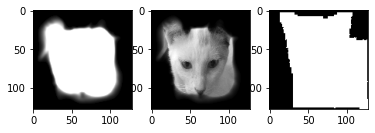

  5%|▍         | 1/21 [00:01<00:26,  1.32s/it]

torch.Size([128, 128])
torch.Size([128, 128])


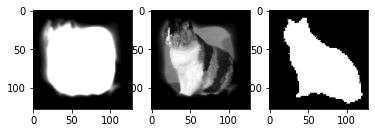

 10%|▉         | 2/21 [00:02<00:22,  1.17s/it]

torch.Size([128, 128])
torch.Size([128, 128])


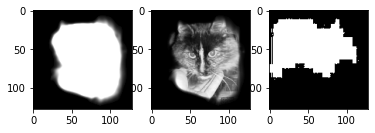

 14%|█▍        | 3/21 [00:03<00:20,  1.13s/it]

torch.Size([128, 128])
torch.Size([128, 128])


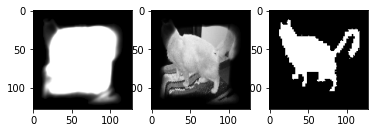

 19%|█▉        | 4/21 [00:04<00:18,  1.11s/it]

torch.Size([128, 128])
torch.Size([128, 128])


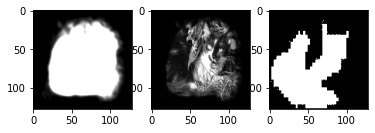

 24%|██▍       | 5/21 [00:05<00:17,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


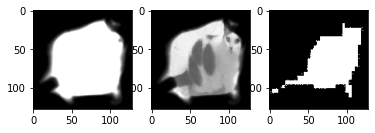

 29%|██▊       | 6/21 [00:06<00:16,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


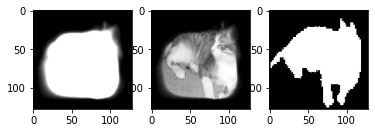

 33%|███▎      | 7/21 [00:07<00:15,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


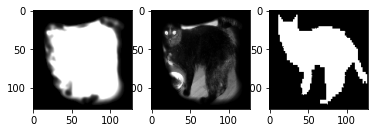

 38%|███▊      | 8/21 [00:08<00:14,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


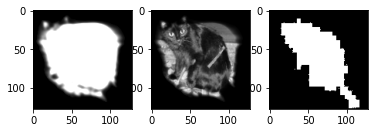

 43%|████▎     | 9/21 [00:10<00:13,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


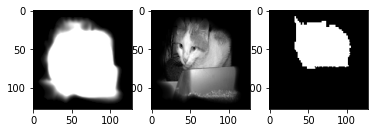

 48%|████▊     | 10/21 [00:11<00:12,  1.09s/it]

torch.Size([128, 128])
torch.Size([128, 128])


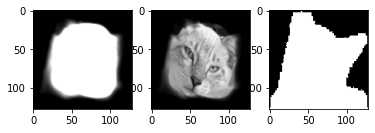

 52%|█████▏    | 11/21 [00:12<00:10,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


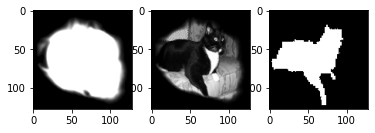

 57%|█████▋    | 12/21 [00:13<00:09,  1.09s/it]

torch.Size([128, 128])
torch.Size([128, 128])


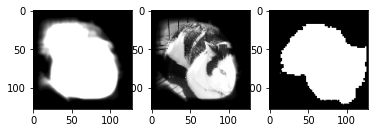

 62%|██████▏   | 13/21 [00:14<00:08,  1.09s/it]

torch.Size([128, 128])
torch.Size([128, 128])


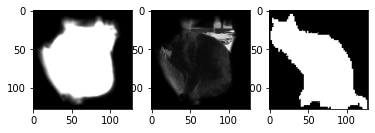

 67%|██████▋   | 14/21 [00:15<00:07,  1.09s/it]

torch.Size([128, 128])
torch.Size([128, 128])


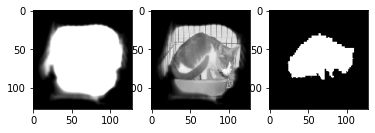

 71%|███████▏  | 15/21 [00:16<00:06,  1.16s/it]

torch.Size([128, 128])
torch.Size([128, 128])


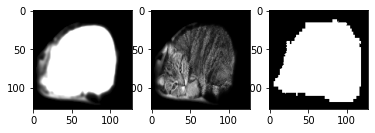

 76%|███████▌  | 16/21 [00:17<00:05,  1.13s/it]

torch.Size([128, 128])
torch.Size([128, 128])


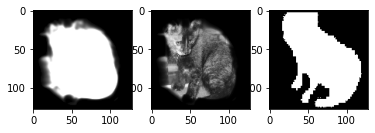

 81%|████████  | 17/21 [00:18<00:04,  1.12s/it]

torch.Size([128, 128])
torch.Size([128, 128])


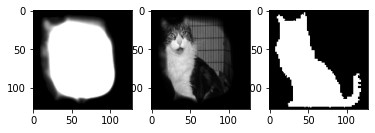

 86%|████████▌ | 18/21 [00:20<00:03,  1.11s/it]

torch.Size([128, 128])
torch.Size([128, 128])


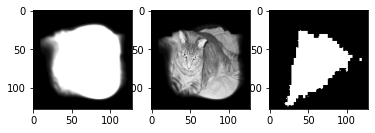

 90%|█████████ | 19/21 [00:21<00:02,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


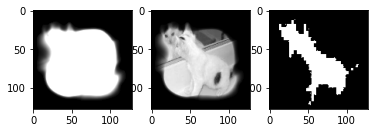

 95%|█████████▌| 20/21 [00:22<00:01,  1.10s/it]

torch.Size([128, 128])
torch.Size([128, 128])


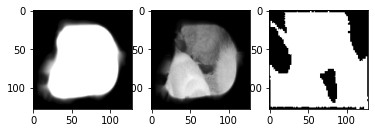

100%|██████████| 21/21 [00:23<00:00,  1.11s/it]

Test loss: 0.19236549380279722


In [21]:
dataset_test = MyDataset(21,'/content/drive/My Drive/A3/cat_data/cat_data', mode='Test', augment=False)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)
running_loss=0
with torch.no_grad():
  for images, labels in tqdm(testloader):
      optimizer.zero_grad()
      input = images.unsqueeze(1)
      labels = labels.unsqueeze(1)
      log_ps = model(input)
      i = log_ps.squeeze()
      l = labels.squeeze()
      print(i.shape)
      print(l.shape)
      final = images.squeeze()
      final = i*final
      
      plt.subplot(1, 3, 1)
      plt.imshow(i,cmap='gray')
      plt.subplot(1, 3, 2)
      plt.imshow(final,cmap='gray')
      plt.subplot(1, 3, 3)
      plt.imshow(l,cmap='gray')
      plt.show()

      loss = criterion(log_ps, labels)
      running_loss += loss.item()
print(f"Test loss: {running_loss/len(testloader)}")

In [12]:
print(l)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])
